## Vanilla FM intro

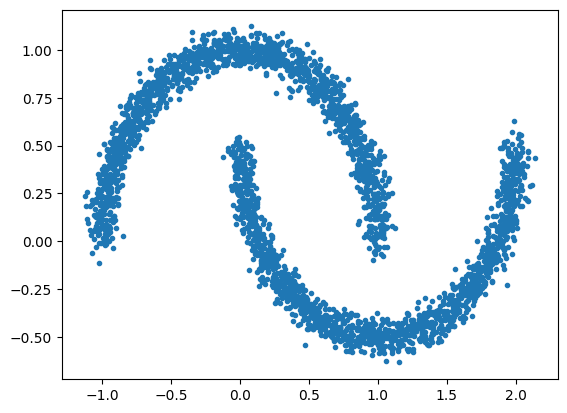

In [3]:

import numpy as np
import matplotlib.pyplot as plt
from typing import List
from tqdm import tqdm
from torchdiffeq import odeint

import torch
import torch.nn as nn
from sklearn.datasets import make_moons

device = 'cpu' # cuda, cpu

x, _ = make_moons(n_samples=3000,noise=0.05)
x = torch.from_numpy(x).float()

plt.figure()
plt.plot(x[:,0].cpu().numpy(),x[:,1].cpu().numpy(), '.')
plt.show()


In [4]:
class MLP(nn.Sequential):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_features: List[int] = [64, 64],
    ):
        layers = []

        for a, b in zip(
            (in_features, *hidden_features),
            (*hidden_features, out_features),
        ):
            layers.extend([nn.Linear(a, b), nn.ELU()])

        super().__init__(*layers[:-1])
        
    def v(self, t, x):
        return self(torch.hstack((t, x)))
    
    def solve(self, t, x):
        t = torch.ones(x.shape[0], device=x.device) * t
        return self.v(t[:,None], x)

    

### Define Loss function and train

In [6]:

def FlowMatchingLoss(model, x):
    t = torch.rand_like(x[..., 0]).unsqueeze(-1)
    z = torch.randn_like(x) 
    y = (1 - t) * x + (1e-4 + (1 - 1e-4) * t) * z 
    u = (1 - 1e-4) * z - x 

    return (model.v(t, y) - u).square().mean()

flow = MLP(3,2, hidden_features=[256] * 3)
flow.to(device)

# Training
optimizer = torch.optim.Adam(flow.parameters(), lr=5e-3)
loss_all = []

for epoch in tqdm(range(3000)):
    subset = torch.randint(0, len(x), (256,))
    x_batch = x[subset]

    optimizer.zero_grad()
    l = FlowMatchingLoss(flow,x_batch)
    l.backward()
    optimizer.step()

    loss_all.append(l.item())

100%|██████████| 3000/3000 [00:07<00:00, 392.73it/s]


### Here we use a standard ODE integrator for inference

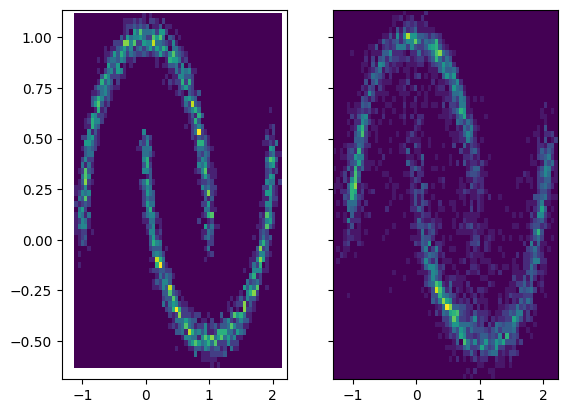

In [7]:
from torchdiffeq import odeint

eps = torch.randn(4096, 2).to(device)
ode_steps = 100
with torch.no_grad():
    traj = odeint(flow.solve, eps,torch.linspace(1, 0., ode_steps, device='cpu'),rtol=1e-4,atol=1e-4)
x_ = traj[-1]

fig, ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].hist2d(x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy(), bins=64)
ax[1].hist2d(x_[:, 0], x_[:, 1], bins=64)
plt.show()

# SD3 like FM

In [ ]:
class MLP(nn.Sequential):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_features: List[int] = [64, 64],
    ):
        layers = []

        for a, b in zip(
            (in_features, *hidden_features),
            (*hidden_features, out_features),
        ):
            layers.extend([nn.Linear(a, b), nn.ELU()])

        super().__init__(*layers[:-1])
        
    def v(self, t, x):
        return self(torch.hstack((t, x)))
    
    def solve(self, t, x):
        t = torch.ones(x.shape[0], device=x.device) * t
        return self.v(t[:,None], x)
